In [210]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [211]:
import torch
import torchvision
import torchvision.transforms.v2
import matplotlib.pyplot as plt

transform = torchvision.transforms.v2.Compose([
    # torchvision.transforms.v2.Resize((96, 96), antialias = True),
    torchvision.transforms.v2.Grayscale(),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    # torchvision.transforms.v2.Normalize(mean, std)
])

train = torchvision.datasets.ImageFolder("faces/training", transform = transform)
test = torchvision.datasets.ImageFolder("faces/testing", transform = transform)

In [212]:
import tqdm
import numpy

train_images = numpy.array([ numpy.array(item[0]).squeeze() for item in tqdm.tqdm(train) ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ numpy.array(item[0]).squeeze() for item in tqdm.tqdm(test) ])
test_labels = numpy.array([ item[1] for item in test ])

train_images.shape, test_images.shape

100%|██████████| 30/30 [00:00<00:00, 2779.59it/s]


((370, 112, 92), (30, 112, 92))

In [213]:
import os
import itertools

import typing

import tqdm
import numpy
import joblib
import gtda.images

import cvtda.utils
import cvtda.topology

def make_diagrams(
    binarizer,
    filtration,
    n_jobs: int = 1
) -> typing.Tuple[numpy.ndarray, numpy.ndarray]:
    dir = f"1/{str(filtration or 'None')}"
    if os.path.exists(f"{dir}/test_features.npy"):
        return 1, 2
    os.makedirs(dir, exist_ok = True)
    
    with joblib.parallel_backend("loky", inner_max_num_threads = n_jobs):
        train = train_images.copy()
        test = test_images.copy()

        if binarizer is not None:
            train = binarizer.fit_transform(train)
            test = binarizer.transform(test)
            
        if filtration is not None:
            train = filtration.fit_transform(train)
            test = filtration.transform(test)
        
        filtrations_to_diagrams = cvtda.topology.FiltrationsToDiagrams(verbose = False, n_jobs = n_jobs)
        train = filtrations_to_diagrams.fit_transform(train)
        test = filtrations_to_diagrams.transform(test)

    numpy.save(f"{dir}/train_diagrams.npy", train)
    numpy.save(f"{dir}/test_diagrams.npy", test)
    
    if len(train[0]) < 96:
        n_bins = 32
    elif len(train[0]) < 192:
        n_bins = 64
    else:
        n_bins = 128

    with joblib.parallel_backend("loky", inner_max_num_threads = n_jobs):
        digrams_to_features = cvtda.topology.DiagramsToFeatures(batch_size = 500, n_bins = n_bins, verbose = False, n_jobs = n_jobs)
        train = digrams_to_features.fit_transform(train)
        test = digrams_to_features.transform(test)

    numpy.save(f"{dir}/train_features.npy", train)
    numpy.save(f"{dir}/test_features.npy", test)

    return train, test

def process(binarizer_threshold: float) -> typing.Tuple[numpy.ndarray, numpy.ndarray]:
    centers = [ 5, 12, 18, 25 ]
    greyscale_to_filtrations = cvtda.topology.GreyscaleToFiltrations(
        n_jobs = 2,
        radial_filtration_centers = list(itertools.product(centers, centers))
    )
    diagrams = joblib.Parallel(return_as = 'generator', n_jobs = 8)(
        joblib.delayed(make_diagrams)(
            binarizer = gtda.images.Binarizer(threshold = binarizer_threshold, n_jobs = 1),
            filtration = filtration,
            n_jobs = 2
        )
        for filtration in greyscale_to_filtrations.filtrations_
    )
    for train, test in tqdm.tqdm(diagrams, total = len(greyscale_to_filtrations.filtrations_)):
        pass

    make_diagrams(
        binarizer = None,
        filtration = None,
        n_jobs = -1
    )

In [214]:
process(0.4)

100%|██████████| 24/24 [00:00<00:00, 140.09it/s]


In [215]:
train_features = [ ]
test_features = [ ]
for filtration in tqdm.tqdm(os.listdir(f"1/")):
    train_features.append(numpy.load(f"1/{filtration}/train_features.npy"))
    test_features.append(numpy.load(f"1/{filtration}/test_features.npy"))

train_features = numpy.hstack(train_features)
test_features = numpy.hstack(test_features)

train_features.shape, test_features.shape

100%|██████████| 25/25 [00:00<00:00, 1610.84it/s]


((370, 1750), (30, 1750))

In [216]:
import sklearn.preprocessing

selected_standard_scaler = sklearn.preprocessing.StandardScaler()
train_features = selected_standard_scaler.fit_transform(train_features)
test_features = selected_standard_scaler.transform(test_features)

In [217]:
train_features = torch.tensor(train_features, dtype = torch.float32)
test_features = torch.tensor(test_features, dtype = torch.float32)

train_labels = torch.tensor(train_labels, dtype = torch.long)
test_labels = torch.tensor(test_labels, dtype = torch.long)

(19, 1)

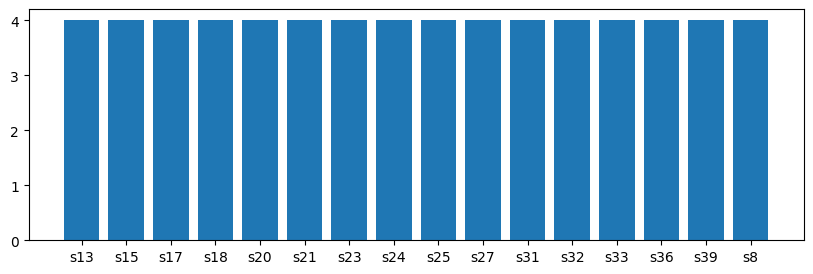

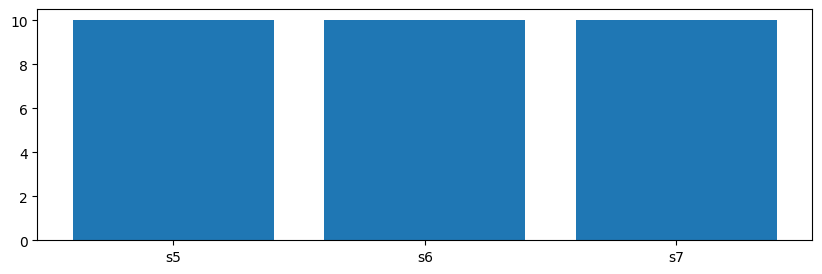

In [218]:
import pytorch_metric_learning.samplers

def show_class_distribtion(labels, classes):
    plt.figure(figsize = (10, 3))
    x, counts = labels.unique(return_counts = True)
    plt.bar(numpy.array(classes)[x], height = counts)

N_EPOCHS = 25
LENGTH_BEFORE_NEW_ITER = 1280
train_mpc_sampler = pytorch_metric_learning.samplers.MPerClassSampler(labels = train_labels, m = 4, length_before_new_iter = LENGTH_BEFORE_NEW_ITER)
train_set = torch.utils.data.TensorDataset(train_features, train_labels)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 64, sampler = train_mpc_sampler)
show_class_distribtion(next(iter(train_loader))[1], train.classes)


test_set = torch.utils.data.TensorDataset(test_features, test_labels)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = len(test_set))
show_class_distribtion(next(iter(test_loader))[1], test.classes)

len(train_loader), len(test_loader)

In [219]:
model = torch.nn.Sequential(
    torch.nn.Dropout(0.3), torch.nn.Linear(1750, 1024), torch.nn.BatchNorm1d(1024), torch.nn.ReLU(),
    torch.nn.Dropout(0.15), torch.nn.Linear(1024, 512), torch.nn.BatchNorm1d(512), torch.nn.ReLU(),
    torch.nn.Linear(512, 256)
)
model(next(iter(test_loader))[0]).shape

torch.Size([30, 256])

In [220]:
MARGIN = 0.1 # Standard value in PyTorch TripletMarginLoss, should be good

In [221]:
import pytorch_metric_learning.miners

train_miner = pytorch_metric_learning.miners.TripletMarginMiner(margin = MARGIN, type_of_triplets = "all")

images, labels = next(iter(train_loader))
embeddings = model(images)
print(embeddings.shape)

indices = train_miner(embeddings, labels)
print(len(indices), indices[0].shape, indices[1].shape, indices[2].shape)

torch.Size([64, 256])
3 torch.Size([6027]) torch.Size([6027]) torch.Size([6027])


In [222]:
import pytorch_metric_learning.losses

criterion = pytorch_metric_learning.losses.TripletMarginLoss(margin = MARGIN)
loss = criterion(embeddings, labels, indices)
print(loss)

tensor(0.0938, grad_fn=<MeanBackward0>)


In [223]:
import pytorch_metric_learning.utils.accuracy_calculator

device = torch.device('cuda')

metrics = pytorch_metric_learning.utils.accuracy_calculator.AccuracyCalculator()
def validate(model: torch.nn.Module) -> dict:
    with torch.no_grad():
        images, targets = next(iter(test_loader))
        model = model.to(device)
        model.eval()
        embeddings = model(images.to(device))
        return metrics.get_accuracy(embeddings, targets.to(device))

validate(model)

{'AMI': 0.7468327705097921,
 'NMI': 0.7649659696235374,
 'mean_average_precision': 0.8664596695651047,
 'mean_average_precision_at_r': 0.7643121693121693,
 'mean_reciprocal_rank': 1.0,
 'precision_at_1': 1.0,
 'r_precision': 0.7888888888888888}

In [224]:
def train(model: torch.nn.Module, n_epochs: int) -> None:
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
    for epoch in range(n_epochs):
        sum_loss = 0
        for (images, targets) in tqdm.tqdm(train_loader, desc = 'Epoch {}'.format(epoch + 1)):
            if len(targets) == 0:
                continue
            model.train() # Enter train mode
            optimizer.zero_grad() # Zero gradients
            embeddings = model(images.to(device))
            indices = train_miner(embeddings, targets)
            loss = criterion(embeddings, targets.to(device), indices)
            loss.backward() # Calculate gradients
            optimizer.step() # Update weights
            sum_loss += loss.item()
        train_loss = sum_loss / len(train_loader)
        metrics = validate(model)
        mean_avg_pr = metrics['mean_average_precision']
        AMI = metrics['AMI']
        NMI = metrics['NMI']
        print(f"Train loss: {train_loss:.5f}, Test MAP: {mean_avg_pr:.5f}, Test AMI: {AMI:.5f}, Test NMI: {NMI:.5f}")

train(model, N_EPOCHS * 2)

Epoch 1: 100%|██████████| 19/19 [00:00<00:00, 79.87it/s]


Train loss: 0.10044, Test MAP: 0.89239, Test AMI: 0.61483, Test NMI: 0.64332


Epoch 2: 100%|██████████| 19/19 [00:00<00:00, 117.26it/s]

Train loss: 0.08269, Test MAP: 0.93060, Test AMI: 1.00000, Test NMI: 1.00000

Epoch 3: 100%|██████████| 19/19 [00:00<00:00, 129.74it/s]


Train loss: 0.07430, Test MAP: 0.93874, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 4: 100%|██████████| 19/19 [00:00<00:00, 132.84it/s]


Train loss: 0.06955, Test MAP: 0.96031, Test AMI: 0.62463, Test NMI: 0.65662


Epoch 5: 100%|██████████| 19/19 [00:00<00:00, 126.98it/s]


Train loss: 0.06809, Test MAP: 0.96440, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 6: 100%|██████████| 19/19 [00:00<00:00, 137.80it/s]


Train loss: 0.06597, Test MAP: 0.95581, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 7: 100%|██████████| 19/19 [00:00<00:00, 144.08it/s]


Train loss: 0.06496, Test MAP: 0.95893, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 8: 100%|██████████| 19/19 [00:00<00:00, 131.13it/s]


Train loss: 0.05775, Test MAP: 0.97254, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 9: 100%|██████████| 19/19 [00:00<00:00, 109.10it/s]


Train loss: 0.05990, Test MAP: 0.99660, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 10: 100%|██████████| 19/19 [00:00<00:00, 142.11it/s]


Train loss: 0.06087, Test MAP: 0.97607, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 11: 100%|██████████| 19/19 [00:00<00:00, 133.57it/s]


Train loss: 0.05886, Test MAP: 0.98218, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 12: 100%|██████████| 19/19 [00:00<00:00, 153.05it/s]


Train loss: 0.05006, Test MAP: 0.98696, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 13: 100%|██████████| 19/19 [00:00<00:00, 156.28it/s]


Train loss: 0.05737, Test MAP: 0.98592, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 14: 100%|██████████| 19/19 [00:00<00:00, 161.19it/s]


Train loss: 0.05610, Test MAP: 0.99243, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 15: 100%|██████████| 19/19 [00:00<00:00, 141.67it/s]


Train loss: 0.05986, Test MAP: 0.99126, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 16: 100%|██████████| 19/19 [00:00<00:00, 148.20it/s]


Train loss: 0.04893, Test MAP: 0.99896, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 17: 100%|██████████| 19/19 [00:00<00:00, 155.77it/s]


Train loss: 0.04709, Test MAP: 0.96857, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 18: 100%|██████████| 19/19 [00:00<00:00, 166.46it/s]


Train loss: 0.05090, Test MAP: 0.98209, Test AMI: 0.68335, Test NMI: 0.70870


Epoch 19: 100%|██████████| 19/19 [00:00<00:00, 158.17it/s]


Train loss: 0.04449, Test MAP: 0.97569, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 20: 100%|██████████| 19/19 [00:00<00:00, 151.78it/s]


Train loss: 0.05038, Test MAP: 0.99613, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 21: 100%|██████████| 19/19 [00:00<00:00, 146.07it/s]


Train loss: 0.04394, Test MAP: 0.98375, Test AMI: 0.78281, Test NMI: 0.79799


Epoch 22: 100%|██████████| 19/19 [00:00<00:00, 147.60it/s]


Train loss: 0.04218, Test MAP: 0.97461, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 23: 100%|██████████| 19/19 [00:00<00:00, 144.93it/s]


Train loss: 0.04648, Test MAP: 0.98604, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 24: 100%|██████████| 19/19 [00:00<00:00, 144.99it/s]


Train loss: 0.04171, Test MAP: 0.97445, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 25: 100%|██████████| 19/19 [00:00<00:00, 149.68it/s]


Train loss: 0.04687, Test MAP: 0.98496, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 26: 100%|██████████| 19/19 [00:00<00:00, 150.49it/s]


Train loss: 0.03364, Test MAP: 0.96594, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 27: 100%|██████████| 19/19 [00:00<00:00, 159.33it/s]


Train loss: 0.04547, Test MAP: 0.98469, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 28: 100%|██████████| 19/19 [00:00<00:00, 162.06it/s]


Train loss: 0.05357, Test MAP: 0.98753, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 29: 100%|██████████| 19/19 [00:00<00:00, 138.13it/s]


Train loss: 0.03638, Test MAP: 0.99263, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 30: 100%|██████████| 19/19 [00:00<00:00, 147.98it/s]


Train loss: 0.03545, Test MAP: 0.98930, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 31: 100%|██████████| 19/19 [00:00<00:00, 183.76it/s]


Train loss: 0.04164, Test MAP: 0.98452, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 32: 100%|██████████| 19/19 [00:00<00:00, 142.74it/s]


Train loss: 0.03782, Test MAP: 0.99720, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 33: 100%|██████████| 19/19 [00:00<00:00, 158.20it/s]


Train loss: 0.04477, Test MAP: 0.98851, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 34: 100%|██████████| 19/19 [00:00<00:00, 162.32it/s]


Train loss: 0.03910, Test MAP: 0.98788, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 35: 100%|██████████| 19/19 [00:00<00:00, 174.91it/s]


Train loss: 0.04457, Test MAP: 0.98147, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 36: 100%|██████████| 19/19 [00:00<00:00, 158.70it/s]


Train loss: 0.03909, Test MAP: 0.98557, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 37: 100%|██████████| 19/19 [00:00<00:00, 152.21it/s]


Train loss: 0.04001, Test MAP: 0.98685, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 38: 100%|██████████| 19/19 [00:00<00:00, 171.39it/s]


Train loss: 0.03210, Test MAP: 0.97973, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 39: 100%|██████████| 19/19 [00:00<00:00, 165.01it/s]


Train loss: 0.05391, Test MAP: 0.99926, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 40: 100%|██████████| 19/19 [00:00<00:00, 162.80it/s]


Train loss: 0.03983, Test MAP: 0.99507, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 41: 100%|██████████| 19/19 [00:00<00:00, 168.01it/s]


Train loss: 0.04040, Test MAP: 0.98748, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 42: 100%|██████████| 19/19 [00:00<00:00, 164.63it/s]


Train loss: 0.03599, Test MAP: 0.98784, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 43: 100%|██████████| 19/19 [00:00<00:00, 161.27it/s]


Train loss: 0.04965, Test MAP: 0.98922, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 44: 100%|██████████| 19/19 [00:00<00:00, 160.27it/s]


Train loss: 0.03121, Test MAP: 0.98340, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 45: 100%|██████████| 19/19 [00:00<00:00, 159.42it/s]


Train loss: 0.03598, Test MAP: 0.99521, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 46: 100%|██████████| 19/19 [00:00<00:00, 175.01it/s]


Train loss: 0.02726, Test MAP: 0.98414, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 47: 100%|██████████| 19/19 [00:00<00:00, 183.92it/s]


Train loss: 0.01673, Test MAP: 0.98978, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 48: 100%|██████████| 19/19 [00:00<00:00, 158.31it/s]


Train loss: 0.02322, Test MAP: 0.99232, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 49: 100%|██████████| 19/19 [00:00<00:00, 162.08it/s]


Train loss: 0.02687, Test MAP: 0.98998, Test AMI: 1.00000, Test NMI: 1.00000


Epoch 50: 100%|██████████| 19/19 [00:00<00:00, 168.23it/s]

Train loss: 0.03367, Test MAP: 0.99280, Test AMI: 1.00000, Test NMI: 1.00000


In [225]:
model.eval()
validate(model)

{'AMI': 1.0,
 'NMI': 1.0,
 'mean_average_precision': 0.9928004608560164,
 'mean_average_precision_at_r': 0.9727880658436214,
 'mean_reciprocal_rank': 1.0,
 'precision_at_1': 1.0,
 'r_precision': 0.974074074074074}

In [226]:
with torch.no_grad():
    test_embeddings = model(test_features.to(device))

In [227]:
import pandas

matrix = [ [ "-1" ] * len(test_labels) for i in range(len(test_labels)) ]
for i, (emb1, label1) in enumerate(zip(test_embeddings, test_labels)):
    for j, (emb2, label2) in enumerate(zip(test_embeddings, test_labels)):
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        matrix[i][j] = "{0:.2f}".format(euc_dist)

pandas.options.display.max_columns = 30
df = pandas.DataFrame(matrix, columns = test_labels.tolist())
df.index = test_labels.tolist()
df

,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2
0,0.00,4.75,7.37,5.81,4.14,4.28,4.95,5.70,4.79,4.61,9.78,9.14,8.09,9.30,11.67,8.38,9.44,7.66,10.72,8.53,11.47,13.27,10.96,12.95,12.06,11.19,11.47,12.24,12.36,12.05
0,4.75,0.00,7.44,7.01,5.47,5.18,6.13,5.45,6.33,6.18,10.77,10.22,9.24,10.36,12.07,9.43,10.25,9.12,11.55,9.27,11.45,12.83,10.84,12.58,12.21,10.99,11.46,12.24,12.30,11.88
0,7.37,7.44,0.00,5.70,6.36,8.79,8.97,6.02,7.38,9.46,9.43,9.56,8.02,9.02,11.27,9.09,9.58,8.48,10.46,10.02,11.16,12.92,10.46,12.57,11.58,11.24,10.94,12.08,11.94,12.08
0,5.81,7.01,5.70,0.00,6.22,6.98,6.09,6.10,4.84,7.53,9.72,9.42,8.11,8.95,11.67,9.35,9.60,8.38,10.74,10.35,12.24,14.15,11.68,13.78,12.73,12.35,12.22,12.96,12.97,13.07
0,4.14,5.47,6.36,6.22,0.00,6.02,7.32,3.98,5.39,7.25,10.23,9.85,8.28,10.10,11.84,8.96,9.99,8.16,10.75,9.49,12.64,14.27,11.92,14.01,12.97,12.11,12.41,13.38,13.49,13.30
0,4.28,5.18,8.79,6.98,6.02,0.00,5.50,7.08,4.90,4.63,10.77,9.58,9.33,10.40,11.96,8.67,9.89,7.92,11.15,8.50,12.13,13.24,11.36,13.05,12.53,11.45,11.72,12.54,12.69,12.46
0,4.95,6.13,8.97,6.09,7.32,5.50,0.00,7.69,5.73,3.54,11.69,11.11,10.36,10.85,13.70,10.65,11.47,10.15,12.82,10.82,13.14,14.68,12.72,14.57,13.56,12.94,13.29,13.90,13.91,13.76
0,5.70,5.45,6.02,6.10,3.98,7.08,7.69,0.00,5.88,7.77,11.37,10.92,9.56,11.14,12.59,10.37,11.02,9.55,11.70,10.74,13.26,15.19,12.71,14.69,13.96,13.22,13.32,14.16,14.22,14.00
0,4.79,6.33,7.38,4.84,5.39,4.90,5.73,5.88,0.00,5.70,9.86,9.00,8.13,9.33,11.37,8.33,9.35,7.57,10.35,9.18,12.45,13.53,11.76,13.58,12.36,11.59,12.09,13.04,13.18,13.08
0,4.61,6.18,9.46,7.53,7.25,4.63,3.54,7.77,5.70,0.00,11.31,10.46,10.08,10.84,12.80,9.70,10.84,9.32,11.90,9.51,12.73,14.16,12.36,13.98,13.21,12.35,12.67,13.41,13.49,13.18


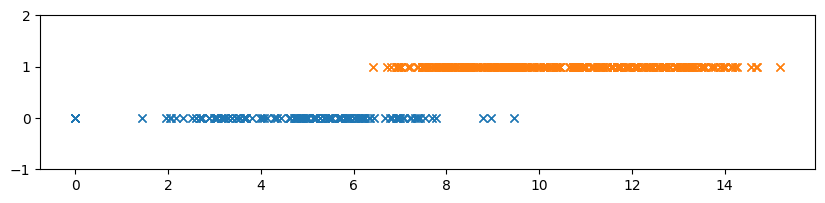

In [228]:

correct_dists = [ ]
incorrect_dists = [ ]
for i, (emb1, label1) in enumerate(zip(test_embeddings, test_labels)):
    for j, (emb2, label2) in enumerate(zip(test_embeddings, test_labels)):
        euc_dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
        if label1 == label2: correct_dists.append(euc_dist)
        else: incorrect_dists.append(euc_dist)

plt.figure(figsize = (10, 2))
plt.ylim(-1, 2)
plt.plot(correct_dists, numpy.zeros_like(correct_dists), 'x')
plt.plot(incorrect_dists, numpy.ones_like(incorrect_dists), 'x')

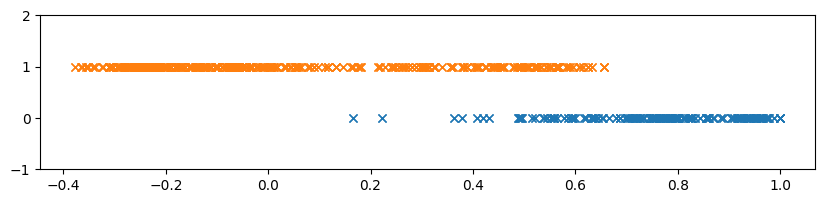

In [229]:
correct_dists = [ ]
incorrect_dists = [ ]
for i, (emb1, label1) in enumerate(zip(test_embeddings, test_labels)):
    for j, (emb2, label2) in enumerate(zip(test_embeddings, test_labels)):
        cos_dist = torch.nn.functional.cosine_similarity(emb1, emb2, dim = 0).item()
        if label1 == label2: correct_dists.append(cos_dist)
        else: incorrect_dists.append(cos_dist)

plt.figure(figsize = (10, 2))
plt.ylim(-1, 2)
plt.plot(correct_dists, numpy.zeros_like(correct_dists), 'x')
plt.plot(incorrect_dists, numpy.ones_like(incorrect_dists), 'x')